In [1]:
from matplotlib import pyplot as plt
import numpy as np
import json
import os
from argoverse.map_representation.map_api import ArgoverseMap

am = ArgoverseMap() # 여기는 지도를 그리기 위한 API로 https://github.com/argoai/argoverse-api 를 참조하여 api를 설치하신 후에 사용 가능합니다.



In [3]:
root_dir = "ResultsJson/LAST_smoothing_smoothing/"  # Test결과 파일이 있는 위치
raw_data_dir = "data/argoverse_raw/test/" #argoverse rawdata(csv 파일)이 저장되어 있는 위치


file_list = os.listdir(root_dir)


index = 0
json_dict = {}
with open(root_dir + file_list[index]) as json_data:
    json_dict = json.load(json_data)

preds = np.array(json_dict['preds'])
waypoint_preds = np.array(json_dict['waypoint_preds'])
agent_labels = np.array(json_dict['agent_labels'])


In [4]:
import math
from shapely.geometry import LineString

def draw(AGENT, AV, json_dict):
    def denormalization(arr, angle, translation_x, translation_y): # 테스트 결과근 normalize되서 나오므로 이를 다시 denormalization 시키는 코드

        theta = (angle)/180*math.pi
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c, -s), (s, c)))

        #rotate
        arr = np.array([R.dot(arr[...,:2][i].reshape((2,1))).flatten() for i in range(len(arr[...,:2]))])

        #translate
        arr[...,0] += translation_x
        arr[...,1] += translation_y
        arr[...,0] += (AGENT[19,0] - AGENT[0,0])
        arr[...,1] += (AGENT[19,1] - AGENT[0,1])
        return arr
    
    plt.figure(figsize=(8, 8))
    x_mean = np.array(json_dict['preds'])[0,:,0,0].mean()
    y_mean = np.array(json_dict['preds'])[0,:,0,1].mean()

    angle_ans = -json_dict['rotation']

    xmin, xmax, ymin,ymax = [9999], [-9999], [9999], [-9999]

    json_dict['preds'] = [[np.array(json_dict['preds'])[0][i] - min(json_dict['preds'][0][i][:2]) for i in range(len(json_dict['preds'][0]))]]    # calculate x's mean and y's mean in predict

    for p in json_dict['preds'][0]:
        p = denormalization(np.array(p), angle_ans, -json_dict['translation'][0], -json_dict['translation'][1])
        plt.plot(p[...,0], p[...,1])
        plt.scatter(p[...,0][0], p[...,1][0])
        plt.scatter(p[...,0][-1], p[...,1][-1], linewidth=2)
        xmin, xmax = min(np.append(xmin, p[...,0])), max(np.append(xmax, p[...,0]))
        ymin, ymax = min(np.append(ymin, p[...,1])), max(np.append(ymax, p[...,1]))
        

    plt.plot(AGENT[...,0],AGENT[...,1], color='blue')
    plt.scatter(AGENT[...,0][-1],AGENT[...,1][-1], color='blue',linewidth=8)
    plt.scatter(AGENT[...,0][19],AGENT[...,1][19], color='blue')
    plt.plot(AV[...,0],AV[...,1], color='black')
    plt.scatter(AV[...,0][-1],AV[...,1][-1], color='black')

    xmin = min(np.append(np.append(AGENT[...,0], AV[...,0]),xmin))
    xmax = max(np.append(np.append(AGENT[...,0], AV[...,0]),xmax))
    ymin = min(np.append(np.append(AGENT[...,1], AV[...,1]),ymin))
    ymax = max(np.append(np.append(AGENT[...,1], AV[...,1]),ymax))
    
    #draw map
    local_lane_polygons = am.find_local_lane_polygons([xmin, xmax, ymin, ymax], city_name)
    print(xmin, xmax, ymin, ymax)
    for l in local_lane_polygons:
        plt.plot(l[...,0],l[...,1], linewidth='0.5', color='gray')
    plt.show()




0
1522.7868324074493 1597.4703107447015 233.7830555610514 252.66287432565812


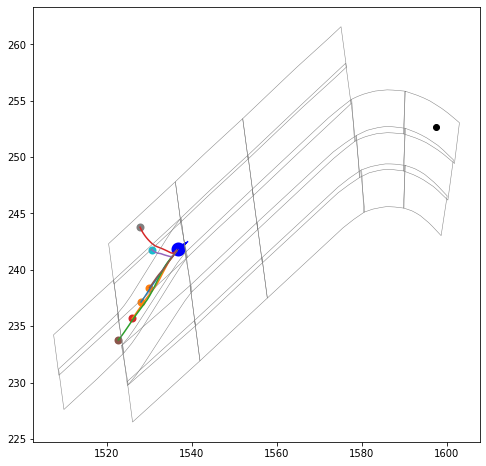

1
112.68196834413786 171.60422012644628 3259.811582397616 3263.6702018461247


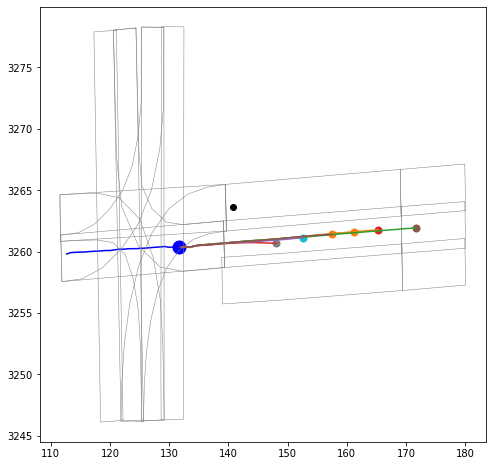

2
-272.9232590458293 -269.54033897757887 2932.1284815941412 3003.1301822748783


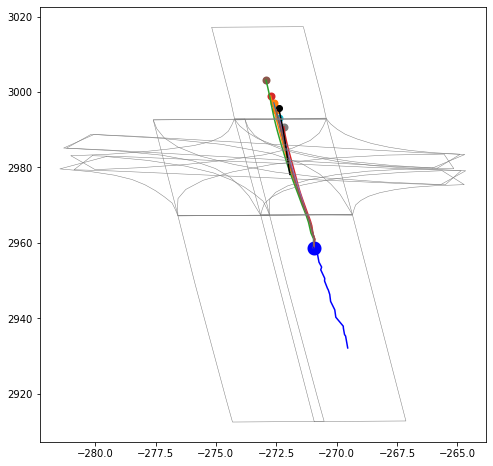

3
114.86881836917824 120.8896463250476 3307.785289459656 3396.526180173051


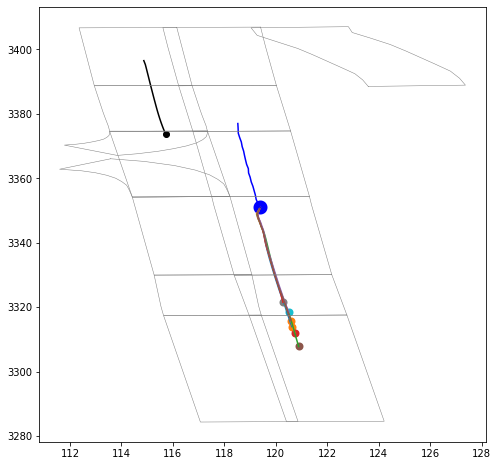

4
1553.1498792961984 1612.9210391345614 249.85321001698938 261.3099237880421


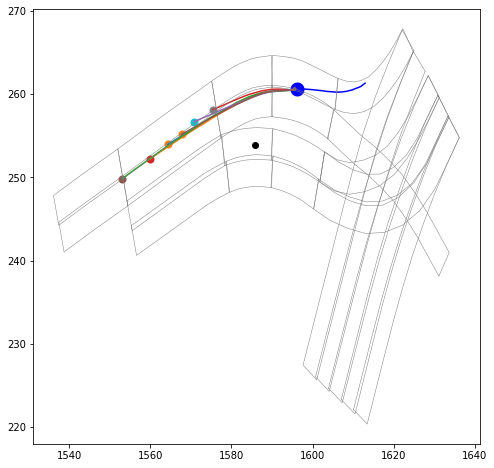

5
-255.90497459937362 -251.07592053061921 2544.1037545466197 2588.2885450303934


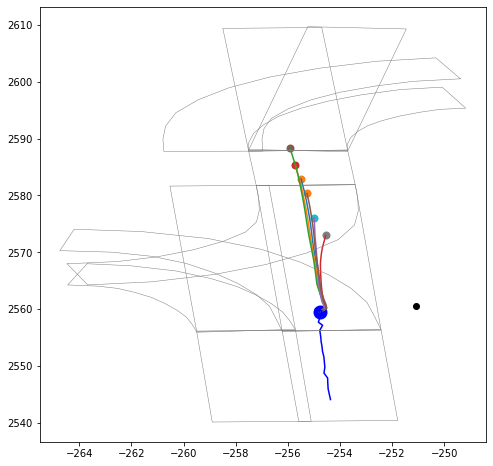

6
1180.449113330507 1220.3604253753422 106.15940229002899 124.43453539912888


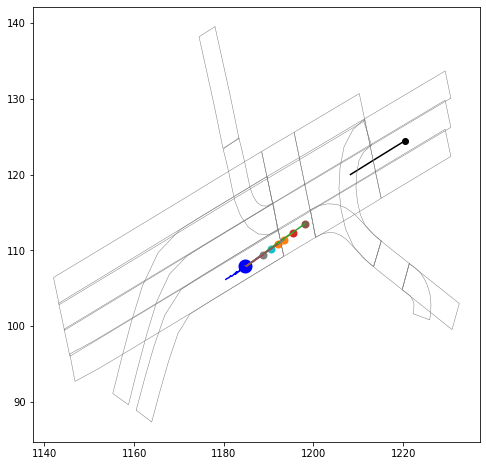

7
1596.7267383441983 1637.2311318484494 212.4378203544396 281.53411633751546


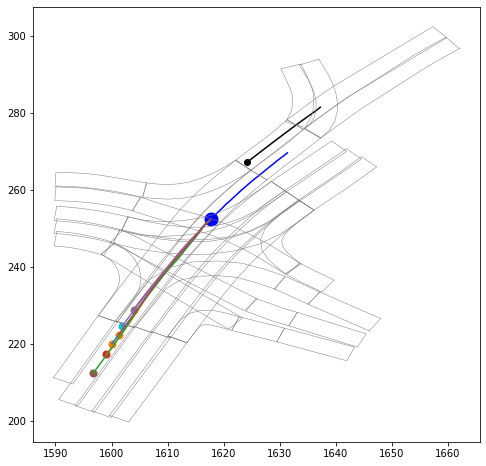

8
1156.589903557767 1204.0856073280636 91.6940833710967 122.7397929724284


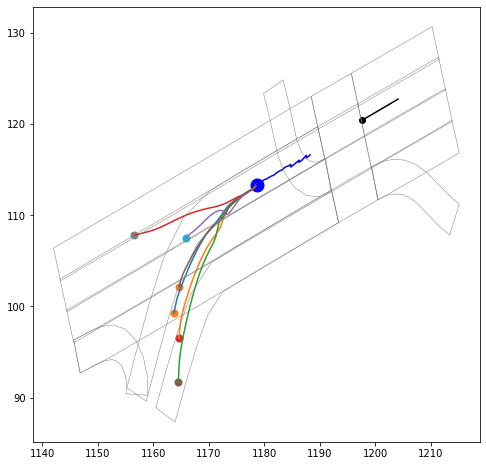

9
1351.054212020613 1415.7342449211567 515.5211588006506 551.2323798803036


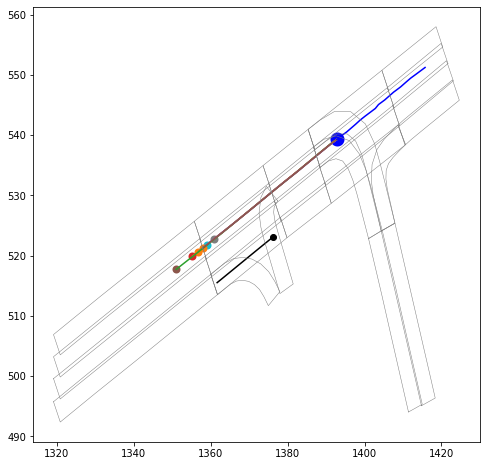

In [5]:
import csv

for i in range(0,10): # 전체를 다 그리기는 힘드므로 일부만 시각화
    print(i)
    file_list = sorted(os.listdir(root_dir), key=lambda a : str(a.split('.')[0]))
    index = i

    json_dict = {}

    with open(root_dir + file_list[index], 'r') as json_data:
        json_dict = json.load(json_data)


    AV = []
    AGENT = []
    city_name = ""

    with open(raw_data_dir + json_dict['csv_file']) as csvfile: #val: 33, Test:25
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in spamreader:
            if row[2] == 'AGENT':
                AGENT.append([float(row[3]), float(row[4])])

            elif row[2] == "AV":
                AV.append([float(row[3]), float(row[4])])

            city_name = row[-1]
    AV = np.array(AV)
    AGENT = np.array(AGENT)

    draw(AGENT, AV, json_dict)